In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/celebal-anaverse-n/train.parquet
/kaggle/input/celebal-anaverse-n/sample_submission.parquet
/kaggle/input/celebal-anaverse-n/test.parquet


In [6]:
import requests

try:
    response = requests.get("https://pypi.org", timeout=5)
    if response.status_code == 200:
        print("✅ Internet access is available.")
    else:
        print("⚠️ Received response, but status code:", response.status_code)
except Exception as e:
    print("❌ Internet access failed. Error:", e)


✅ Internet access is available.


**Set Up Kaggle Notebook**

In [7]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

import xgboost as xgb
import lightgbm as lgb


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load datasets (specific to Kaggle environment)
train_df = pd.read_parquet('/kaggle/input/celebal-anaverse-n/train.parquet')
test_df = pd.read_parquet('/kaggle/input/celebal-anaverse-n/test.parquet')
submission_df = pd.read_parquet('/kaggle/input/celebal-anaverse-n/sample_submission.parquet')

# Preview data
print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
train_df.head()


2025-04-11 09:19:23.284621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744363163.766650      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744363163.905233      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train Data Shape: (1639424, 7)
Test Data Shape: (409856, 7)


,Date,X1,X2,X3,X4,X5,target
0,2020-12-16,1.518921,5.463154,1.0,2.718282,2.890372,0
1,2020-12-16,1.546509,5.458010,1.0,2.718282,2.833213,1
2,2020-12-16,1.645427,5.456560,1.0,7.389056,2.890372,1
3,2020-12-16,1.652022,5.458479,1.0,2.718282,2.890372,1
4,2020-12-16,1.695538,5.466709,1.0,2.718282,2.890372,0


**Explore and Analyze the Data**

Train Data Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1639424 entries, 0 to 1639423
Data columns (total 7 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   Date    1639424 non-null  datetime64[ns]
 1   X1      1639424 non-null  float64       
 2   X2      1639424 non-null  float64       
 3   X3      1639424 non-null  float64       
 4   X4      1639424 non-null  float64       
 5   X5      1639424 non-null  float64       
 6   target  1639424 non-null  object        
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 87.6+ MB

Missing values in training data:
Date      0
X1        0
X2        0
X3        0
X4        0
X5        0
target    0
dtype: int64

Statistical summary of training data:
                                Date            X1            X2  \
count                        1639424  1.639424e+06  1.639424e+06   
mean   2022-12-03 07:23:43.817145600  1.139258e+00  5.488189e+00   
min 

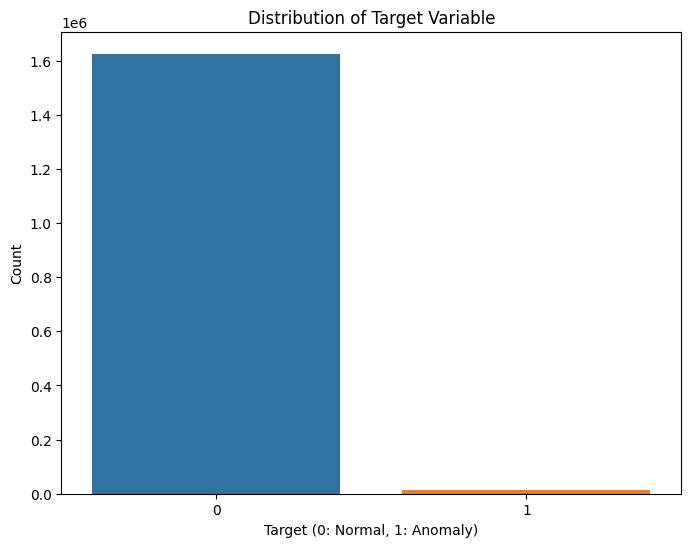

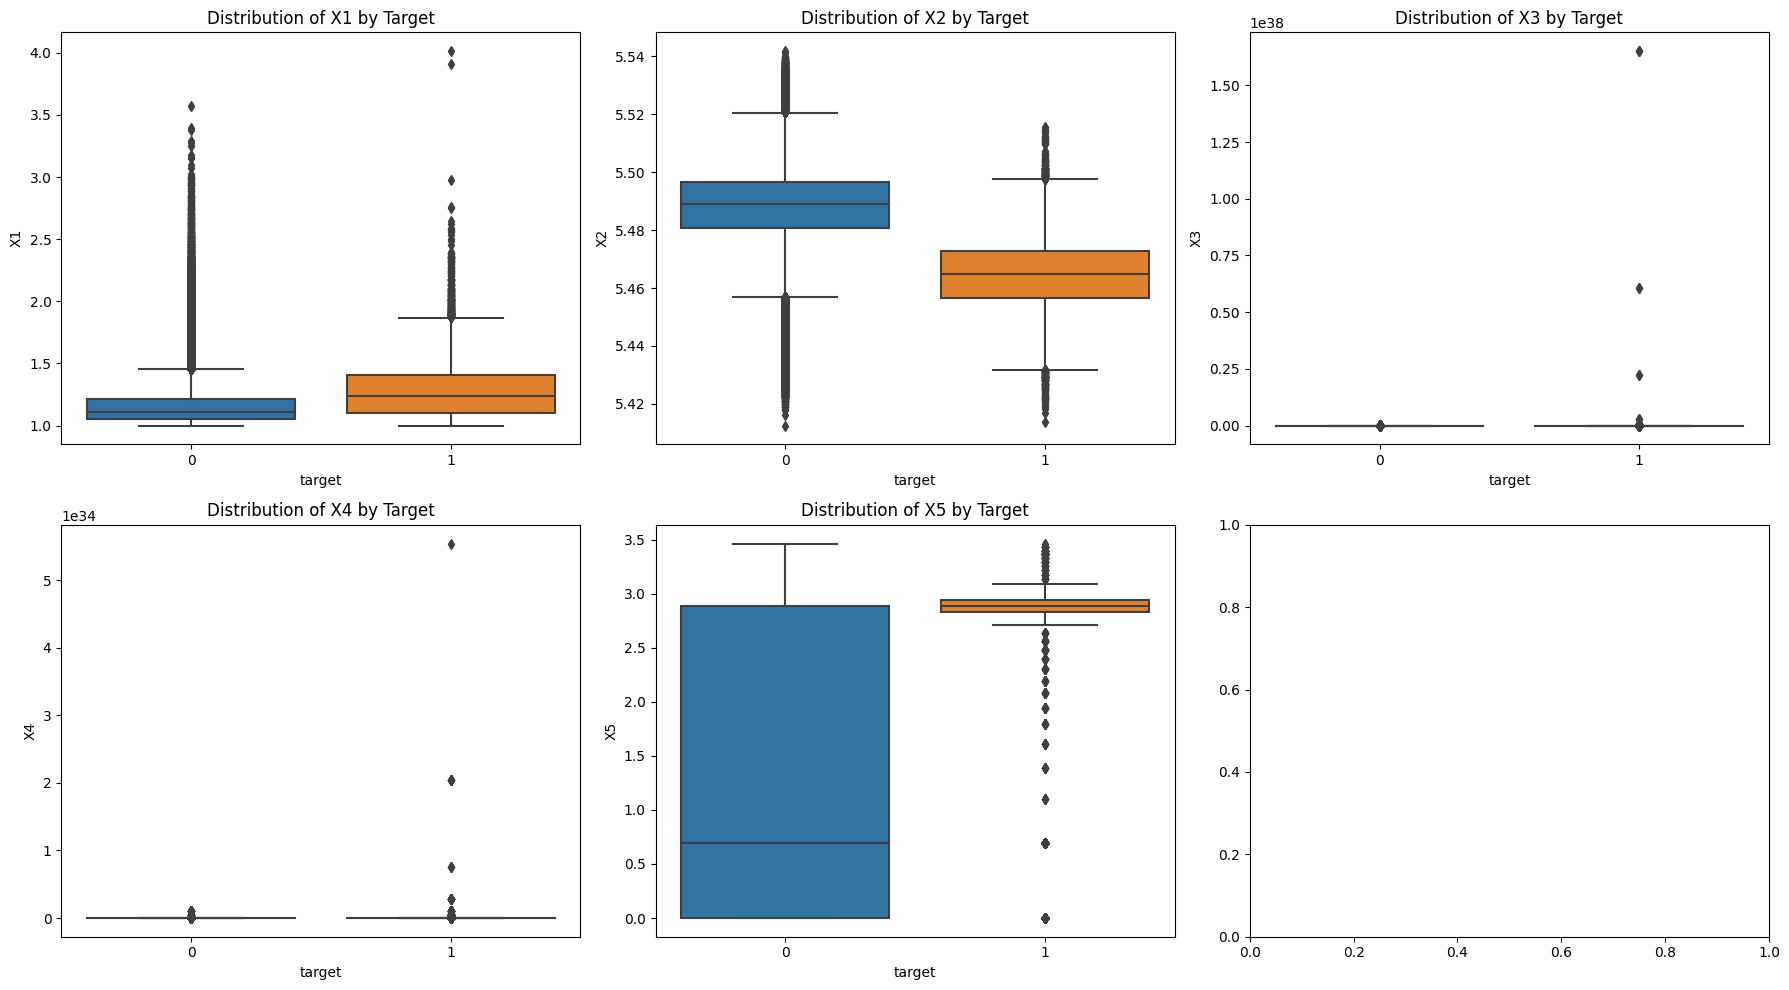

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated a

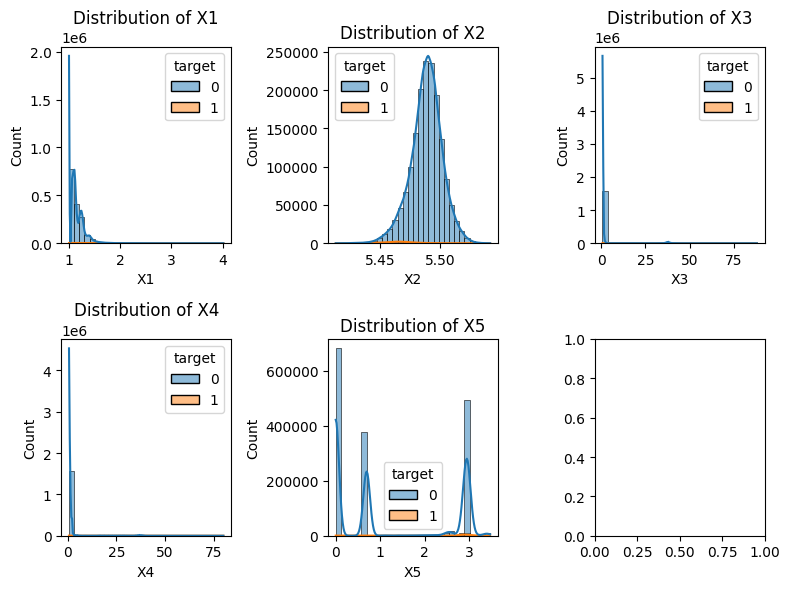

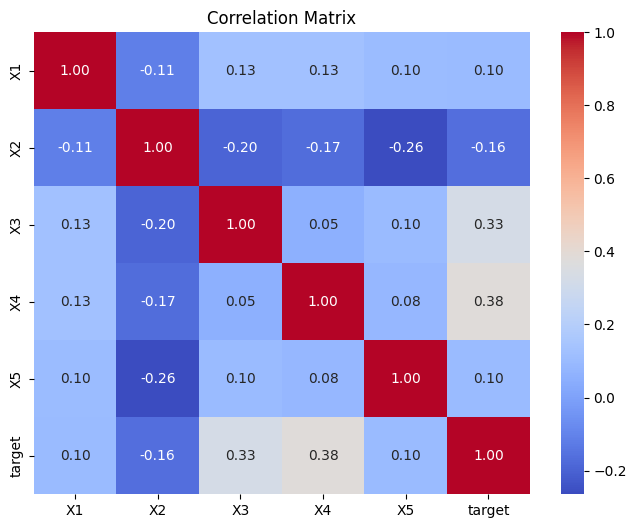

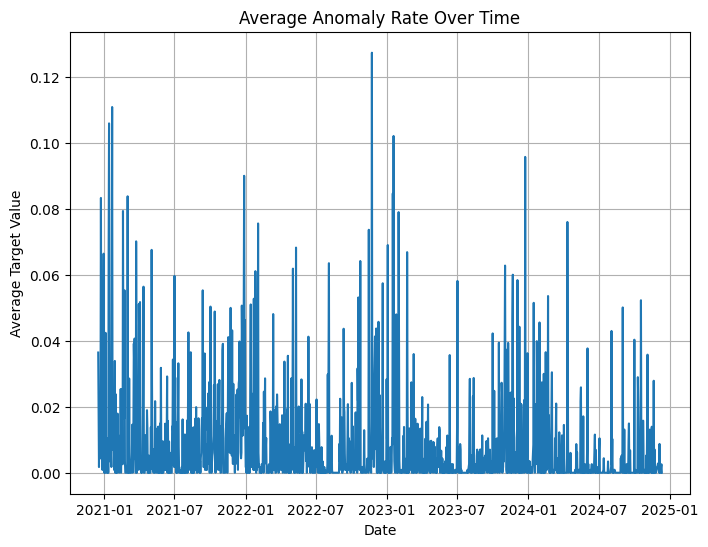

In [8]:
# Examine the data in more detail
print("Train Data Information:")
train_df.info()

# Check for missing values
print("\nMissing values in training data:")
print(train_df.isnull().sum())

# Statistical summary
print("\nStatistical summary of training data:")
print(train_df.describe())

# Check target variable distribution
print("\nTarget variable distribution:")
print(train_df['target'].value_counts())
print(train_df['target'].value_counts(normalize=True).round(4))

# Convert Date to datetime type if it's not already
if train_df['Date'].dtype == 'object':
    train_df['Date'] = pd.to_datetime(train_df['Date'])
    test_df['Date'] = pd.to_datetime(test_df['Date'])

# Plot target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='target', data=train_df)
plt.title('Distribution of Target Variable')
plt.xlabel('Target (0: Normal, 1: Anomaly)')
plt.ylabel('Count')
plt.show()

# Analyze feature distributions based on target
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
features = ['X1', 'X2', 'X3', 'X4', 'X5']

for i, feature in enumerate(features):
    row, col = i // 3, i % 3
    sns.boxplot(x='target', y=feature, data=train_df, ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature} by Target')

plt.tight_layout()
plt.show()

# Replace inf values with NaN to avoid seaborn/pandas FutureWarnings
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN values if any (you can choose imputation too)
train_df.dropna(inplace=True)

# Fix target data type
train_df['target'] = train_df['target'].astype(int)

# Handle extreme values in X3 and X4 using log1p transform
for col in ['X3', 'X4']:
    train_df[col] = np.log1p(train_df[col])


# Distribution of features
fig, axes = plt.subplots(2, 3, figsize=(8, 6))

for i, feature in enumerate(features):
    row, col = i // 3, i % 3
    sns.histplot(data=train_df, x=feature, hue='target', kde=True, ax=axes[row, col], bins=30)
    axes[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

# Correlation analysis
plt.figure(figsize=(8, 6))
correlation = train_df.drop(columns=['Date']).corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Ensure target is numeric before aggregation
train_df['target'] = pd.to_numeric(train_df['target'], errors='coerce')

# Time series analysis
if 'Date' in train_df.columns:
    date_anomalies = train_df.groupby('Date')['target'].mean().reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(date_anomalies['Date'], date_anomalies['target'])
    plt.title('Average Anomaly Rate Over Time')
    plt.xlabel('Date')
    plt.ylabel('Average Target Value')
    plt.grid(True)
    plt.show()



In [9]:
print(train_df[['X3', 'X4']].describe())


                 X3            X4
count  1.639424e+06  1.639424e+06
mean   1.773386e+00  1.856724e+00
std    6.042252e+00  5.728174e+00
min    6.931472e-01  6.931472e-01
25%    6.931472e-01  6.931472e-01
50%    6.931472e-01  6.931472e-01
75%    6.931472e-01  1.313262e+00
max    8.800000e+01  8.000000e+01


**Feature Engineering**

Train data shape after feature engineering: (1639424, 56)
New features added: {'X4_to_X5_ratio', 'X5_zscore', 'X1_zscore', 'X1_X2_diff', 'X1_X2', 'cumulative_anomaly_rate', 'X2_log', 'range_X', 'X4_log', 'X5_rolling_std', 'X2_squared', 'X3_is_outlier', 'X1_to_X2_ratio', 'X2_is_outlier', 'X1_X5', 'day', 'X5_squared', 'days_since_last_anomaly', 'X4_rolling_std', 'X1_squared', 'X3_rolling_mean', 'X3_log', 'sensor_entropy', 'X3_squared', 'X4_squared', 'X2_zscore', 'X4_zscore', 'outlier_count', 'min_X', 'X5_is_outlier', 'X1_log', 'X1_is_outlier', 'X3_rolling_std', 'X2_rolling_mean', 'X1_rolling_std', 'day_of_week', 'X2_rolling_std', 'X2_X5_diff', 'X2_X5', 'X5_log', 'month', 'X4_rolling_mean', 'X5_rolling_mean', 'max_X', 'mean_X', 'X3_zscore', 'X4_is_outlier', 'std_X', 'X1_rolling_mean'}


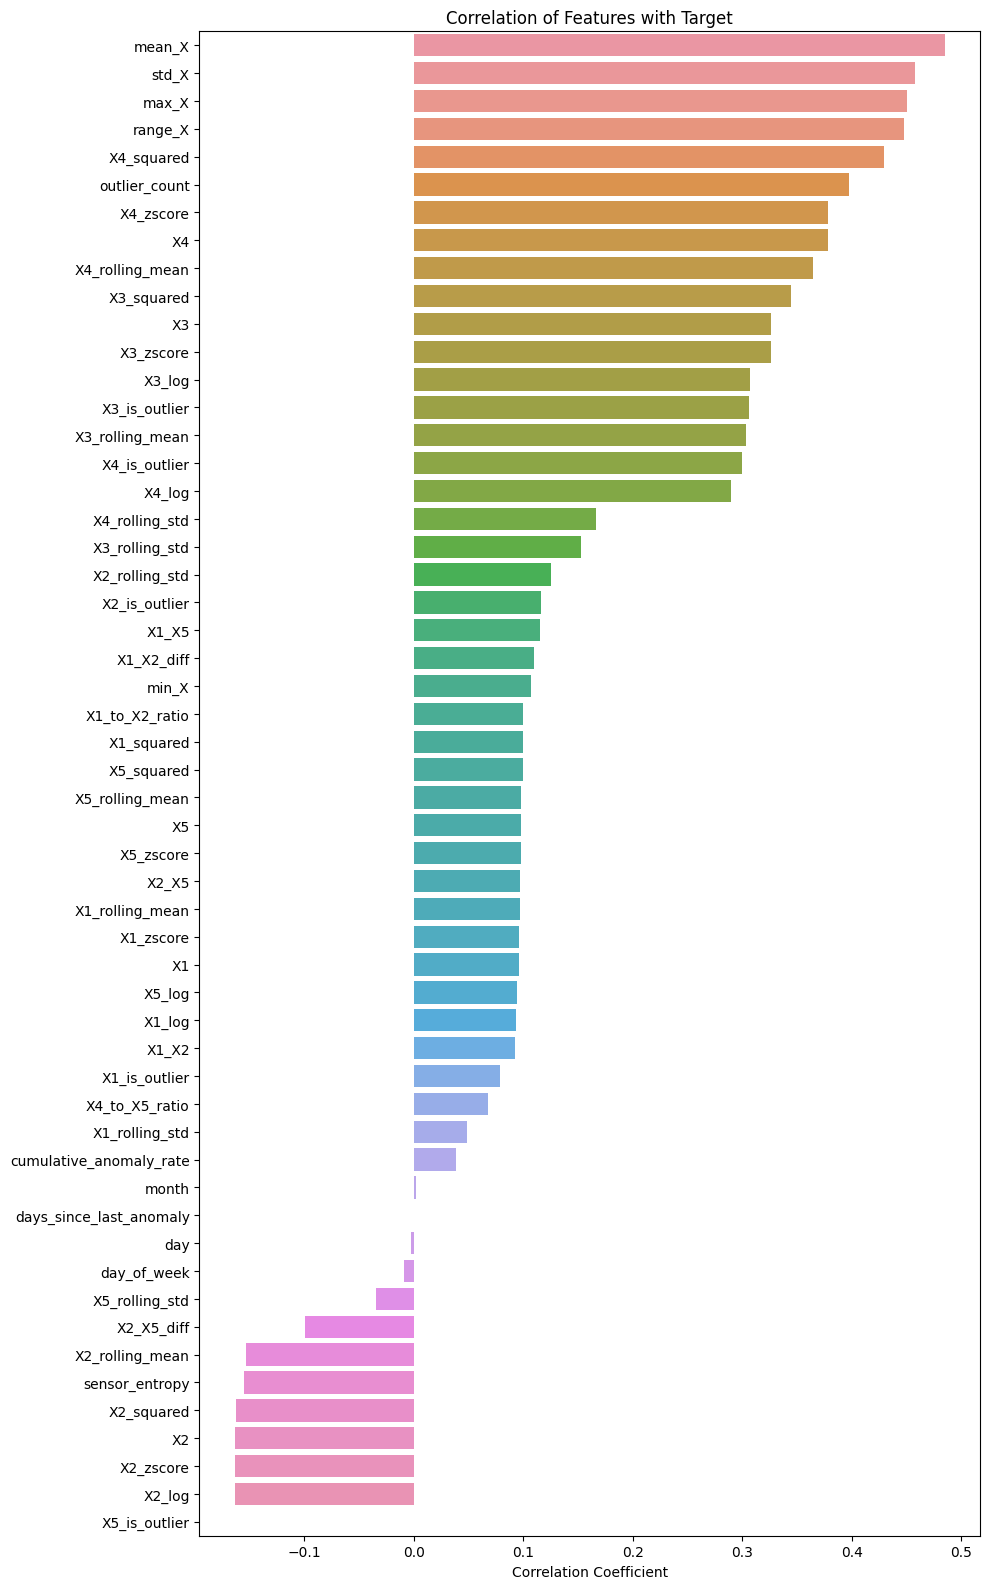

In [10]:
# Feature engineering function
def engineer_features(df, is_train=True):
    new_df = df.copy()
    
    # Ensure datetime column is in datetime format
    if 'Date' in new_df.columns and not np.issubdtype(new_df['Date'].dtype, np.datetime64):
        new_df['Date'] = pd.to_datetime(new_df['Date'])

    # 1. Extract date components
    if 'Date' in new_df.columns:
        new_df['day_of_week'] = new_df['Date'].dt.dayofweek
        new_df['month'] = new_df['Date'].dt.month
        new_df['day'] = new_df['Date'].dt.day
    
    sensor_cols = ['X1', 'X2', 'X3', 'X4', 'X5']

    # 2. Polynomial features
    for col in sensor_cols:
        new_df[f'{col}_squared'] = new_df[col] ** 2
    
    # 3. Interaction features
    new_df['X1_X2'] = new_df['X1'] * new_df['X2']
    new_df['X1_X5'] = new_df['X1'] * new_df['X5']
    new_df['X2_X5'] = new_df['X2'] * new_df['X5']
    
    # 4. Statistical row-wise features
    new_df['mean_X'] = new_df[sensor_cols].mean(axis=1)
    new_df['std_X'] = new_df[sensor_cols].std(axis=1)
    new_df['max_X'] = new_df[sensor_cols].max(axis=1)
    new_df['min_X'] = new_df[sensor_cols].min(axis=1)
    new_df['range_X'] = new_df['max_X'] - new_df['min_X']
    
    # 5. Differences and Ratios
    new_df['X1_X2_diff'] = new_df['X1'] - new_df['X2']
    new_df['X2_X5_diff'] = new_df['X2'] - new_df['X5']
    new_df['X1_to_X2_ratio'] = new_df['X1'] / (new_df['X2'] + 1e-10)
    new_df['X4_to_X5_ratio'] = new_df['X4'] / (new_df['X5'] + 1e-10)

    # 6. Rolling statistics
    for col in sensor_cols:
        new_df[f'{col}_rolling_mean'] = new_df[col].rolling(window=3, min_periods=1).mean()
        new_df[f'{col}_rolling_std'] = new_df[col].rolling(window=3, min_periods=1).std()

    # 7. Outlier flags and count
    for col in sensor_cols:
        mean = new_df[col].mean()
        std = new_df[col].std()
        new_df[f'{col}_is_outlier'] = ((new_df[col] > mean + 3 * std) | (new_df[col] < mean - 3 * std)).astype(int)
    new_df['outlier_count'] = new_df[[f'{col}_is_outlier' for col in sensor_cols]].sum(axis=1)

    # 8. Log transform features
    for col in sensor_cols:
        new_df[f'{col}_log'] = np.log1p(new_df[col])

    # 9. Z-score features
    for col in sensor_cols:
        new_df[f'{col}_zscore'] = (new_df[col] - new_df[col].mean()) / (new_df[col].std() + 1e-10)

    # 10. Entropy across sensor columns
    from scipy.stats import entropy
    new_df['sensor_entropy'] = new_df[sensor_cols].apply(lambda row: entropy(np.abs(row.values) + 1e-10), axis=1)

    # 11. Cumulative anomaly rate (train only)
    if is_train and 'target' in new_df.columns:
        new_df['cumulative_anomaly_rate'] = new_df['target'].expanding().mean()

    # 12. Days since last anomaly (train only)
    if is_train and 'target' in new_df.columns and 'Date' in new_df.columns:
        last_anomaly_time = None
        time_since_last_anomaly = []

        for i, row in new_df.iterrows():
            if row['target'] == 1:
                last_anomaly_time = row['Date']
                time_since_last_anomaly.append(0)
            elif last_anomaly_time is None:
                time_since_last_anomaly.append(np.nan)
            else:
                time_since_last_anomaly.append((row['Date'] - last_anomaly_time).days)

        new_df['days_since_last_anomaly'] = time_since_last_anomaly
        new_df['days_since_last_anomaly'] = new_df['days_since_last_anomaly'].ffill().fillna(0)



    # 13. Fill NaNs
    new_df = new_df.fillna(0)

    return new_df


# Apply feature engineering
train_engineered = engineer_features(train_df)
test_engineered = engineer_features(test_df)

# Determine features present in both train and test (excluding original columns and 'target')
common_features = list(set(train_engineered.columns) & set(test_engineered.columns) - set(train_df.columns) - {'target'})

# OPTIONAL SCALING
scaler = StandardScaler()
train_engineered[common_features] = scaler.fit_transform(train_engineered[common_features])
test_engineered[common_features] = scaler.transform(test_engineered[common_features])

print("Train data shape after feature engineering:", train_engineered.shape)
print("New features added:", set(train_engineered.columns) - set(train_df.columns))

# Visualize correlation matrix after feature engineering to identify most relevant features
# Select only numerical columns
numeric_cols = train_engineered.select_dtypes(include=[np.number]).columns
correlation = train_engineered[numeric_cols].corr()

# Plot correlation matrix (focusing only on correlation with target)
plt.figure(figsize=(10, 16))
target_corr = correlation['target'].sort_values(ascending=False)
target_corr = target_corr.drop('target')  # Remove self-correlation
sns.barplot(x=target_corr.values, y=target_corr.index)
plt.title('Correlation of Features with Target')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.show()

**Data Preprocessing**

In [13]:
# Prepare features and target
def prepare_data(df, is_train=True):
    # Drop date column as we've extracted features from it
    X = df.drop(columns=['Date'])
    
    # Drop ID column if present
    if 'ID' in X.columns:
        X = X.drop(columns=['ID'])

    # If training data, separate target
    if is_train and 'target' in X.columns:
        y = X['target']
        X = X.drop(columns=['target'])
    else:
        y = None

    return X, y


# Prepare training data
X_train_full, y_train = prepare_data(train_engineered)
X_test, _ = prepare_data(test_engineered, is_train=False)

# Check for any missing values and handle them
print("Missing values in X_train_full:")
print(X_train_full.isnull().sum().sum())
print("Missing values in X_test:")
print(X_test.isnull().sum().sum())

# If there are missing values, impute them
if X_train_full.isnull().sum().sum() > 0:
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    X_train_full = pd.DataFrame(imputer.fit_transform(X_train_full), columns=X_train_full.columns)
    X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Check class distribution to understand imbalance
print("Target distribution in training set:")
print(y_train.value_counts(normalize=True))

# 👉 Add missing columns to test and val sets
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0
    if col not in X_val.columns:
        X_val[col] = 0

# Align test and validation data with training data columns
X_val = X_val[X_train.columns]
X_test = X_test[X_train.columns]

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Training data shape:", X_train_scaled.shape)
print("Validation data shape:", X_val_scaled.shape)
print("Test data shape:", X_test_scaled.shape)


Missing values in X_train_full:
0
Missing values in X_test:
0
Target distribution in training set:
target
0    0.991438
1    0.008562
Name: proportion, dtype: float64
Training data shape: (1311539, 54)
Validation data shape: (327885, 54)
Test data shape: (409856, 54)


In [14]:
print("Unique values in y_train:", y_train.unique())
print("Number of classes:", y_train.nunique())


Unique values in y_train: [0 1]
Number of classes: 2


**Model Training and Evaluation**


----- Decision Tree -----
Model: Decision Tree
Accuracy: 0.9949
Precision: 0.9949
Recall: 0.9949
F1 Score: 0.9949

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325077
           1       0.70      0.71      0.70      2808

    accuracy                           0.99    327885
   macro avg       0.85      0.85      0.85    327885
weighted avg       0.99      0.99      0.99    327885



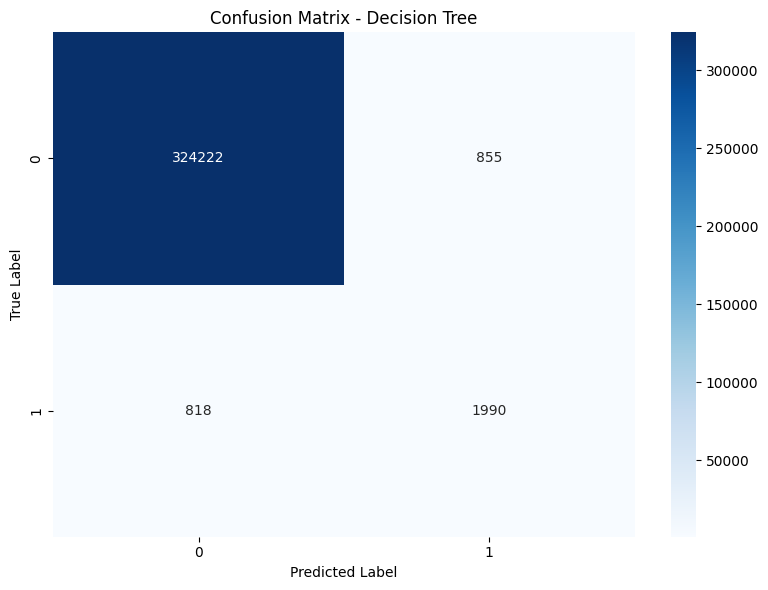


----- Random Forest -----
Model: Random Forest
Accuracy: 0.9963
Precision: 0.9961
Recall: 0.9963
F1 Score: 0.9960

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325077
           1       0.93      0.62      0.75      2808

    accuracy                           1.00    327885
   macro avg       0.96      0.81      0.87    327885
weighted avg       1.00      1.00      1.00    327885



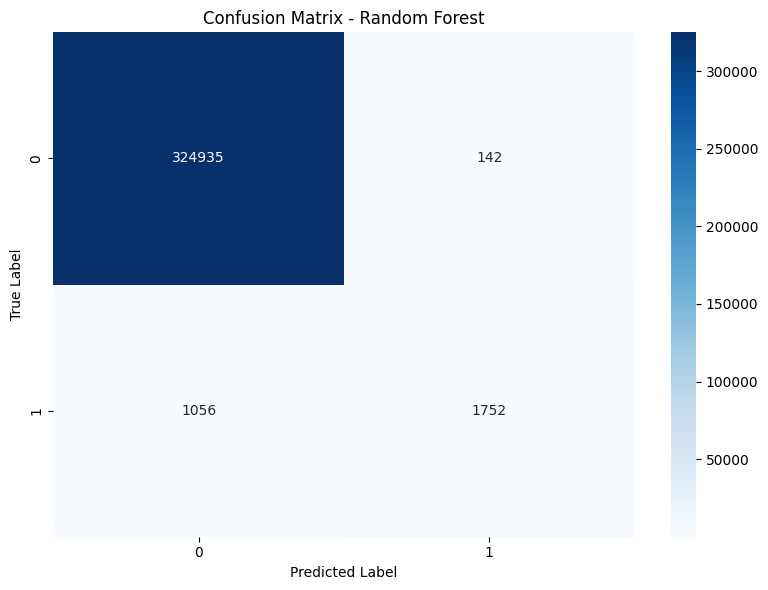


----- XGBoost -----
Model: XGBoost
Accuracy: 0.9967
Precision: 0.9965
Recall: 0.9967
F1 Score: 0.9965

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325077
           1       0.90      0.69      0.78      2808

    accuracy                           1.00    327885
   macro avg       0.95      0.84      0.89    327885
weighted avg       1.00      1.00      1.00    327885



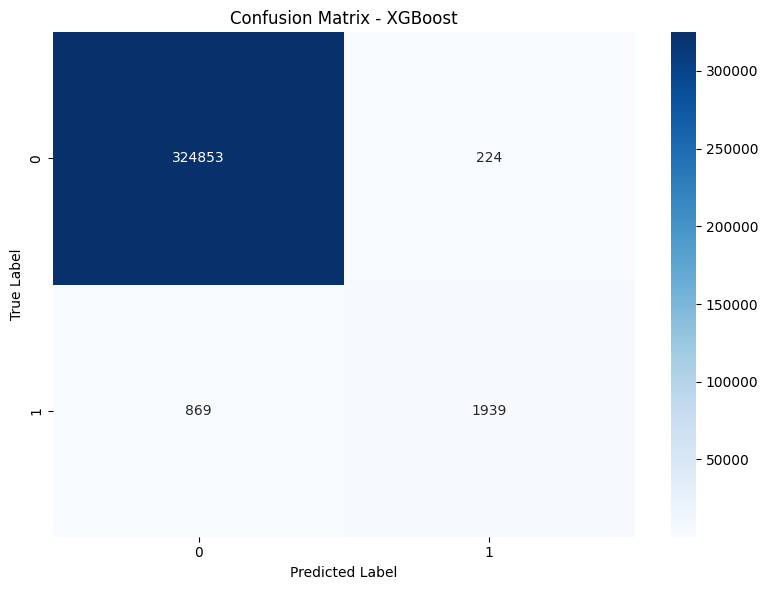


----- LightGBM -----
[LightGBM] [Info] Number of positive: 11230, number of negative: 1300309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.153051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9066
[LightGBM] [Info] Number of data points in the train set: 1311539, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.008562 -> initscore=-4.751768
[LightGBM] [Info] Start training from score -4.751768
Model: LightGBM
Accuracy: 0.9955
Precision: 0.9952
Recall: 0.9955
F1 Score: 0.9952

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    325077
           1       0.81      0.63      0.71      2808

    accuracy                           1.00    327885
   macro avg       0.90      0.81      0.85    327885
weighted avg       1.00      1.00    

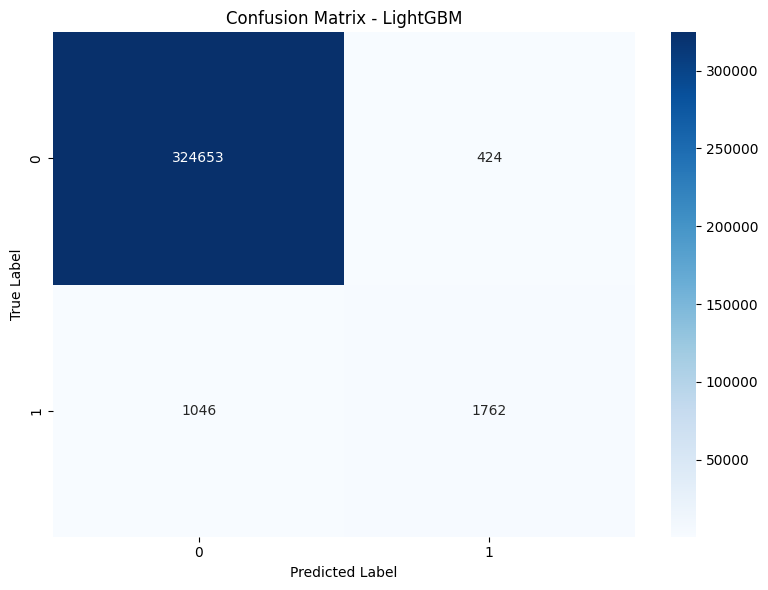


----- Neural Network -----


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1744365430.101864      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744365430.102538      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/10


I0000 00:00:1744365435.381949     158 service.cc:148] XLA service 0x7b55880042e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744365435.388448     158 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744365435.388469     158 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1744365435.828631     158 cuda_dnn.cc:529] Loaded cuDNN version 90300


 116/2562 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9427 - loss: 0.2276

I0000 00:00:1744365437.717587     158 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2562/2562 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - accuracy: 0.9888 - loss: 0.0430 - val_accuracy: 0.9943 - val_loss: 0.0164
Epoch 2/10
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9940 - loss: 0.0179 - val_accuracy: 0.9944 - val_loss: 0.0157
Epoch 3/10
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9942 - loss: 0.0169 - val_accuracy: 0.9946 - val_loss: 0.0152
Epoch 4/10
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9943 - loss: 0.0164 - val_accuracy: 0.9945 - val_loss: 0.0150
Epoch 5/10
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9945 - loss: 0.0159 - val_accuracy: 0.9947 - val_loss: 0.0147
Epoch 6/10
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9945 - loss: 0.0157 - val_accuracy: 0.9947 - val_loss: 0.0147
Epoch 7/10
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9945 - loss: 0.0156 - val_accuracy: 0.9948 - val_loss: 0.0145
Epoch 8/10
2562/2562 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9946 - loss: 0.0153 - val_accura

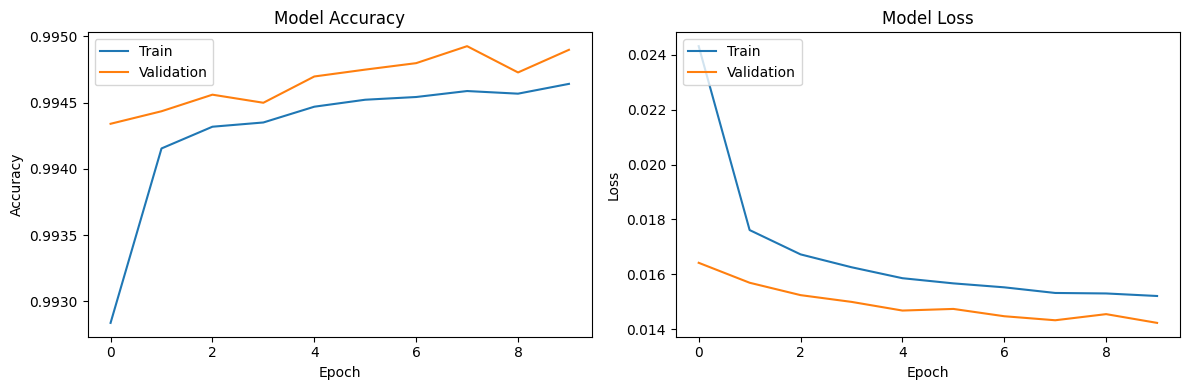

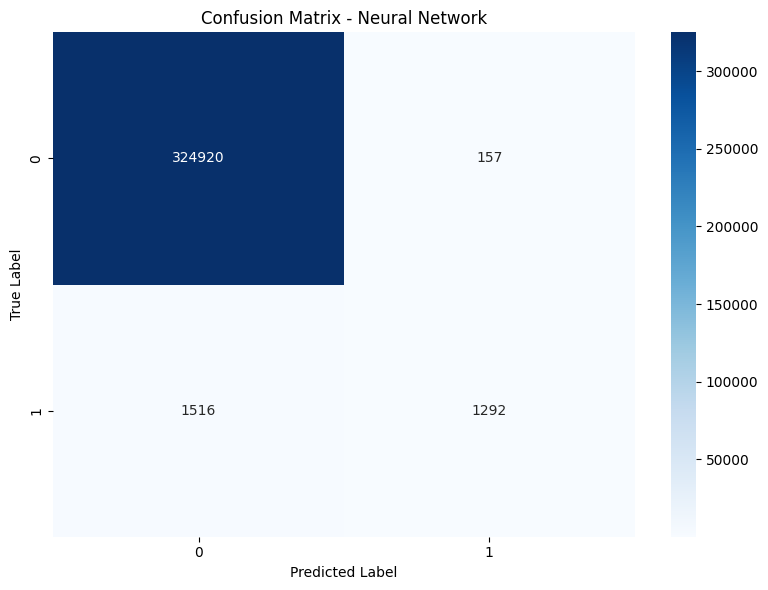

In [16]:
# Dictionary to store model results
model_results = {}

# Function to evaluate models
def evaluate_model(model, X_train, X_val, y_train, y_val, model_name):
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_val)
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')
    recall = recall_score(y_val, y_pred, average='weighted')
    f1 = f1_score(y_val, y_pred, average='weighted')
    
    # Store results
    model_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }
    
    # Print results
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()
    
    return model

# Train and evaluate different models


# 4. Decision Tree
print("\n----- Decision Tree -----")
dt_model = DecisionTreeClassifier(random_state=42)
evaluate_model(dt_model, X_train_scaled, X_val_scaled, y_train, y_val, "Decision Tree")

# 5. Random Forest
print("\n----- Random Forest -----")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
evaluate_model(rf_model, X_train_scaled, X_val_scaled, y_train, y_val, "Random Forest")

# 6. XGBoost
print("\n----- XGBoost -----")
xgb_model = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
evaluate_model(xgb_model, X_train_scaled, X_val_scaled, y_train, y_val, "XGBoost")

# 7. LightGBM
print("\n----- LightGBM -----")
lgb_model = lgb.LGBMClassifier(random_state=42)
evaluate_model(lgb_model, X_train_scaled, X_val_scaled, y_train, y_val, "LightGBM")


# 8. Neural Network
print("\n----- Neural Network -----")
def create_neural_network():
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

nn_model = create_neural_network()
history = nn_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=512,
    verbose=1
)

# Evaluate NN model
y_pred_proba = nn_model.predict(X_val_scaled)
y_pred = (y_pred_proba > 0.5).astype('int')

# Calculate metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

# Store results
model_results['Neural Network'] = {
    'model': nn_model,
    'accuracy': accuracy,
    'precision': precision,
    'recall': recall,
    'f1_score': f1
}

# Print results
print(f"Model: Neural Network")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()